**Assignment 01**

**Index Number: 190108X**                       
**Name: Chathuranga M.M.P.**

**Question 1**

The given intensity transform is generated by using following three ranges and applied to the image using **cv.LUT()** method. When we compare the output image with the original image, we can see that the lower and higher color values haven’t changed due to the transformation, but the values in middle range have changed into higher values. It is the reason to have more white areas in the output image.

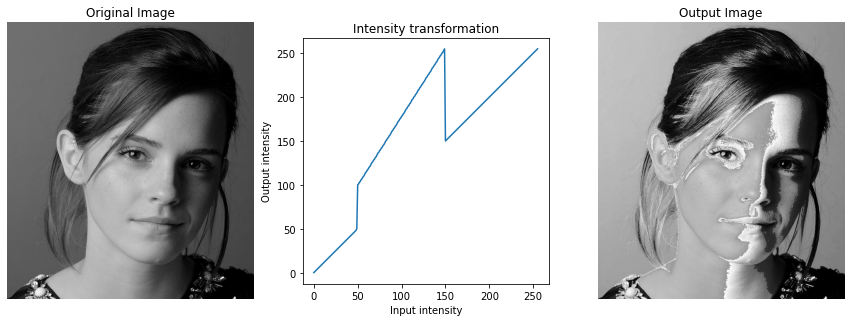

In [16]:
# make the transform ranges
range1=np.linspace(0,50,50)
range2=np.linspace(100,255,100)
range3=np.linspace(150,255,106)
transform=np.concatenate((range1,range2,range3),axis=0).astype(np.uint8) # combine all the ranges to a single array
img_new=cv.LUT(img,transform) # perform the intensity transformation on the image

**Question 2 (a) - White matter**

White means the color values closer to 255. By using an intensity transformation like below, we can filter out the white matter.

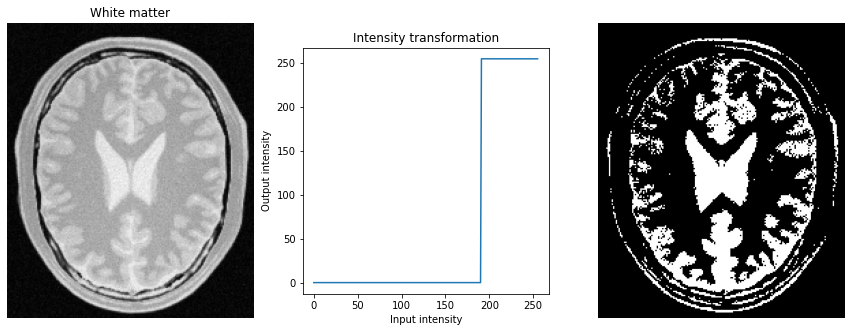

In [19]:
# make the transform ranges
range1=np.linspace(0,0,191)
range2=np.linspace(255,255,65)
transform=np.concatenate((range1,range2),axis=0).astype(np.uint8)# combine all the ranges to a single array
img_new=cv.LUT(img,transform) # perform the intensity transformation on the image

**Question 2 (b) - Gray matter**

To filter the gray matter, we need to reduce lower and higher color values to 0 and increase the middle range color values to 255. The following intensity transformation is designed to do this. We can see the highlighted gray matter in output image.

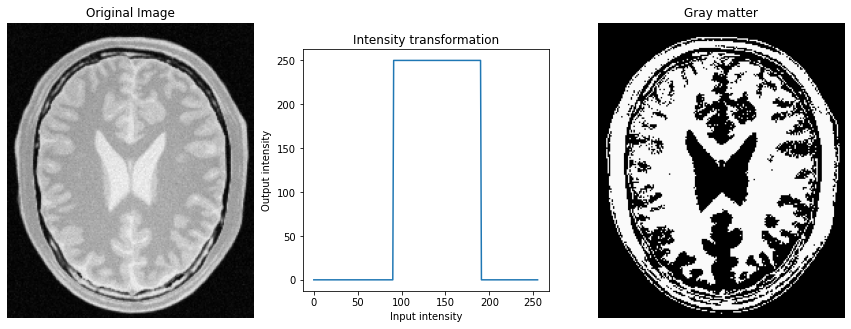

In [22]:
# make the transform ranges
range1=np.linspace(0,0,91)
range2=np.linspace(250,250,100)
range3=np.linspace(0,0,65)
transform=np.concatenate((range1,range2,range3),axis=0).astype(np.uint8) # combine all the ranges to a single array
img_new=cv.LUT(img,transform) # perform the intensity transformation on the image

**Question 3**

First, we need to generate the transform array using the defined gamma value. Then after splitting the image into corresponding color planes in color space (L, a and b), we can apply the transform to **L** plane using look up table method (**cv.LUT( )**). The histograms for both original and output images are shown below.

Text(0.5, 1.0, 'Histogram of Corrected Image (Gamma - 0.4)')

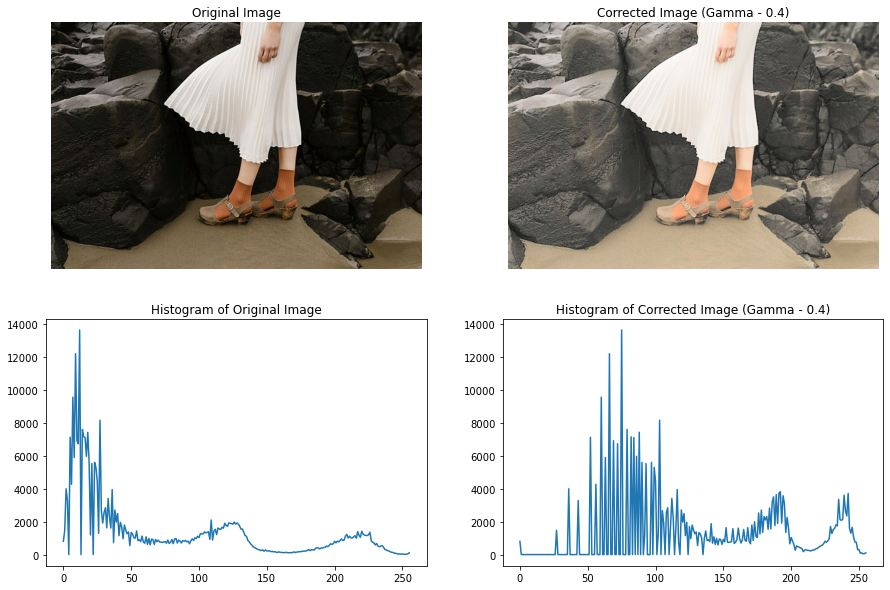

In [1]:
gamma=0.4
transform=np.array([(p/255)**gamma*255 for p in range(0,256)]).astype(np.uint8)
L,a,b=cv.split(lab_img)
l_img=cv.LUT(L,transform)
new_img=img.copy()
new_img[:,:,0]=l_img
new_img[:,:,1]=lab_img[:,:,1]
new_img[:,:,2]=lab_img[:,:,2]

hist_lab_img=cv.calcHist([lab_img],[0],None,[256],[0,256])
hist_new_img=cv.calcHist([new_img],[0],None,[256],[0,256])

**Question 4**

According to the histogram of original image, we can see that the color values are concentrated in the lower region of values. After the histogram equalization, these values are distributed all over the region and brightness of the image has increased. 

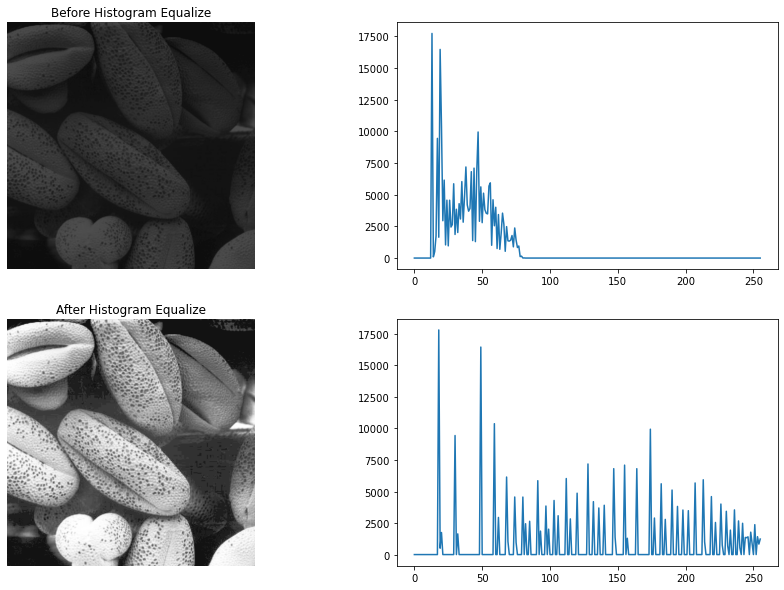

In [25]:
# get the pixel counts for each color value in the image
intensity_nk=np.zeros((256,1))
L=256
for k in range(L):
    pk=0
    for row in img:
        pk+=np.count_nonzero(row == k)
    intensity_nk[k]=[pk]
    
equalizer_nk=intensity_nk.copy()
MN=len(img)*len(img[0]) # Total number of pixels in the image
# generate equalized values for each color value
count=0
while count<len(equalizer_nk):
    equalizer_nk[count][0]=int(round(cum_sum*(L-1)/MN))
    count+=1
# modify the image using equalized color values  
img_new=img.copy()
for m in range(len(img_new)):
    for n in range(len(img_new[m])):
        img_new[m][n]=equalizer_nk[img_new[m][n]][0]
# calculate the values for equalized histogram
equalizer_hist=np.zeros((256,1))
for k in range(L):
    pk=0
    for row in img_new:
        pk+=np.count_nonzero(row == k)
    equalizer_hist[k]=[pk]

**Question 5**

By comparing the normalized SSD values which are comparatively low and the image outputs, we can see that the algorithm has worked quit well. 

In [3]:
def zoom(img,s,method):
    rows_zoomed=img.shape[0]*s
    cols_zoomed=img.shape[1]*s
    if method=='nn': # Nearest-neighbor interpolation
        img_zoomed=np.zeros((rows_zoomed,cols_zoomed,3),dtype=img.dtype)
        for r in range(rows_zoomed-1):
            for c in range(cols_zoomed-1):
                # map the zoomed image array with the small image and update
                mod_r=int(round(r/s))
                mod_c=int(round(c/s))
                if mod_r>=img.shape[0]:
                    mod_r=img.shape[0]-1
                if mod_c>=img.shape[1]:
                    mod_c=img.shape[1]-1
                img_zoomed[r][c]=img[mod_r][mod_c]
        return img_zoomed
    
    else: # Bilinear interpolation
        img_zoomed=np.zeros((rows_zoomed,cols_zoomed,3),dtype=img.dtype)
        for r in range(rows_zoomed-1):
            for c in range(cols_zoomed-1):
                mod_r=r/s
                mod_c=c/s
                # calculate coordinates for four pixels
                left_top,left_bottom=[math.floor(mod_r),math.floor(mod_c)],[math.ceil(mod_r),math.floor(mod_c)]
                right_top,right_bottom=[math.floor(mod_r),math.ceil(mod_c)],[math.ceil(mod_r),math.ceil(mod_c)]
                if left_bottom[0]>=img.shape[0]:
                    left_bottom[0]=img.shape[0]-1
                    right_bottom[0]=img.shape[0]-1
                if right_top[1]>=img.shape[1]:
                    right_top[1]=img.shape[1]-1
                    right_bottom[1]=img.shape[1]-1

                vertical_ratio=mod_r-math.floor(mod_r)
                horiz_ratio=mod_c-math.floor(mod_c)
                # calculate color values using ratios and update zoomed image array
                new_left=img[left_top[0]][left_top[1]]*(1-vertical_ratio)+img[left_bottom[0]][left_bottom[1]]*vertical_ratio
                new_right=img[right_top[0]][right_top[1]]*(1-vertical_ratio)+img[right_bottom[0]][right_bottom[1]]*vertical_ratio
                
                img_zoomed[r][c]=np.rint(new_left*(1-horiz_ratio)+new_right*horiz_ratio)    
        return img_zoomed

ssd_nn=np.sum((img1_org[:,:,0:3]-img1_zoomed_nn[:,:,0:3])**2)
ssd_bl=np.sum((img1_org[:,:,0:3]-img1_zoomed_bl[:,:,0:3])**2)

print('Normalized SSD for Nearest-neighbor interpolation:',ssd_nn/(img1_zoomed_nn.shape[0]*img1_zoomed_nn.shape[1]))
print('Normalized SSD for Bilinear interploation:',ssd_bl/(img1_zoomed_bl.shape[0]*img1_zoomed_bl.shape[1]))

Normalized SSD for Nearest-neighbor interpolation: 120.55043209876543
Normalized SSD for Bilinear interploation: 118.2588705632716


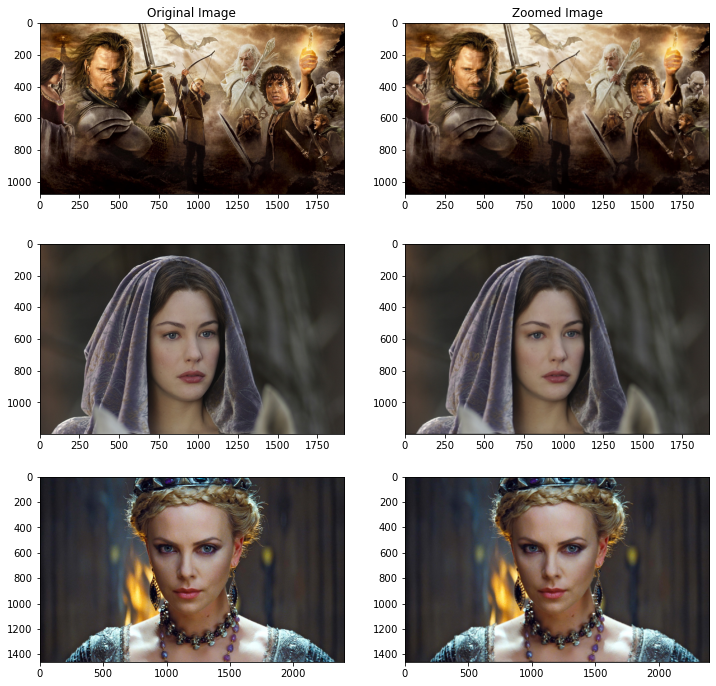

In [4]:
# Nearest-neighbor interpolation

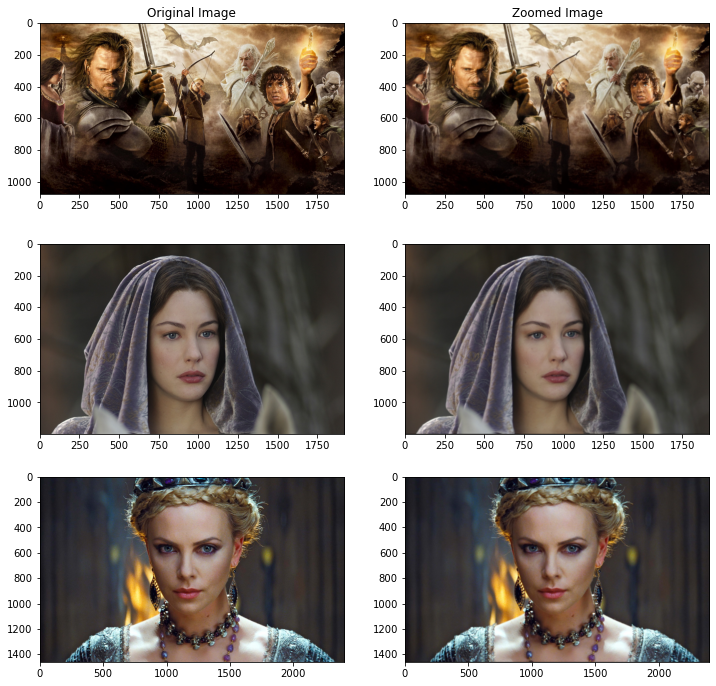

In [5]:
# Bilinear interploation

**Question 6 (a)**

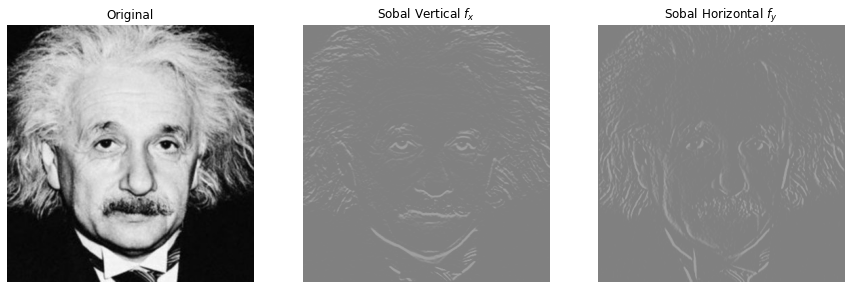

In [15]:
sobel_verticle=np.array([(-1,-2,-1),(0,0,0),(1,2,1)] ,dtype= 'float')
sobel_horizontal=np.array([(-1,0,1),(-2,0,2),(-1,0,1)] ,dtype= 'float')

img_vert_x = cv.filter2D(img,-1,sobel_verticle)
img_horiz_y = cv.filter2D(img,-1,sobel_horizontal)

**Question 6 (b)**

In [16]:
import math
def sobal_filter(img,kernal):
    n=1
    m=1
    kernal_h=math.floor(kernal.shape[0]/2)
    if len(kernal.shape)==1:
        kernal_w=0
        m=2
    else:
        kernal_w=math.floor(kernal.shape[1]/2)
        if kernal.shape[1]==1:
            m=2
    if kernal.shape[0]==1:
        n=2
    img_h,img_w=img.shape
    img_new=img.tolist()
    for row in range(len(img)):
        img_new[row].insert(0,0)
        img_new[row].append(0)
        
    img_new.insert(0,[0 for i in range(img_w+2)])
    img_new.append([0 for i in range(img_w+2)])
    img_new=np.array(img_new)
    img_h_new,img_w_new=img_new.shape
    
    filtered_img=np.zeros(img.shape,float)
    for r in range(kernal_h,img_h_new-kernal_h-n):
        for c in range(kernal_w,img_w_new-kernal_w-m):
            filtered_img[r,c]=np.dot(img_new[r-kernal_h:r+kernal_h+1,c-kernal_w:c+kernal_w+1].flatten(),kernal.flatten())
    return filtered_img

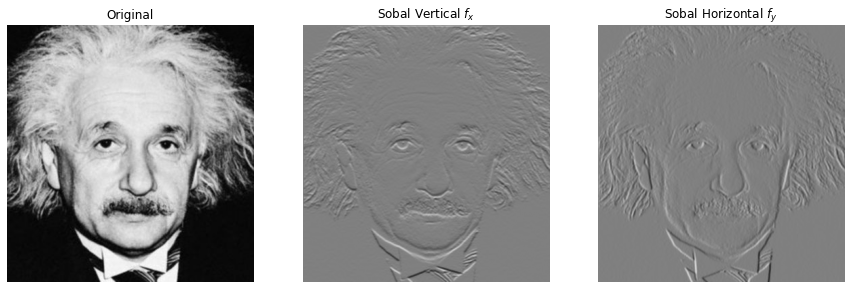

In [17]:
vert_filltered=sobal_filter(img,sobel_verticle)
horiz_filltered=sobal_filter(img,sobel_horizontal)

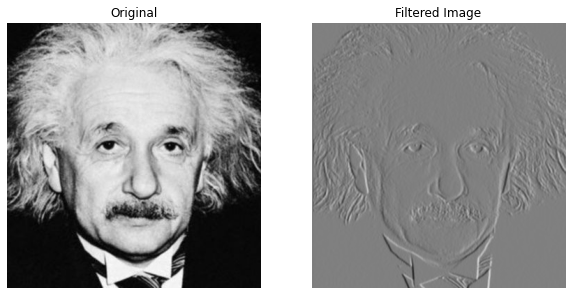

In [18]:
arr_1=np.array([(1),(2),(1)] ,dtype= 'float')
arr_2=np.array([(1,0,-1)] ,dtype= 'float')

arr1_img_filltered=sobal_filter(img,arr_2)
img_final=sobal_filter(arr1_img_filltered,arr_1)

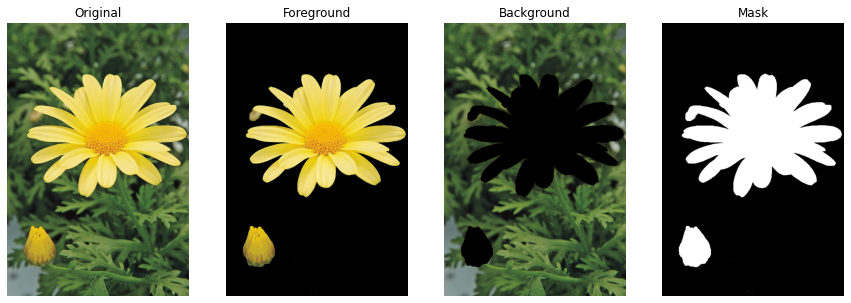

In [20]:
img = cv.imread(r'daisy.jpg',cv.COLOR_RGB2BGR)
mask = np.zeros(img.shape[:2],np.uint8)
bgdModel = np.zeros((1,65),np.float64)
fgdModel = np.zeros((1,65),np.float64)
rectangle = (50,50,550,800)
cv.grabCut(img,mask,rectangle,bgdModel,fgdModel,10,cv.GC_INIT_WITH_RECT)
mask2 = np.where((mask==2)|(mask==0),0,1).astype('uint8')

img_fg = img*mask2[:,:,np.newaxis]
img_bg=np.subtract(img,img_fg)

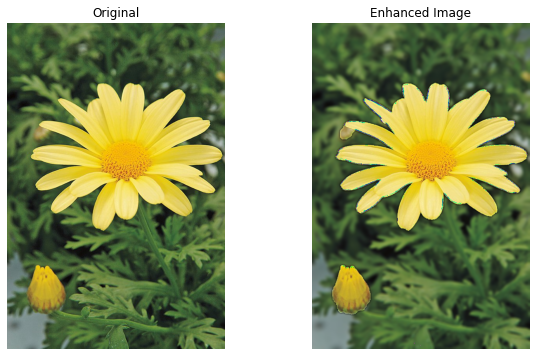

In [21]:
ksize=9
sigma=4
img_gaussian=cv.GaussianBlur(img_bg,(ksize,ksize),sigma)
img_enhanced=np.add(img_fg,img_gaussian)